# Implementation of Partner Selection Procedures

This notebook demonstrates the usage of the `vine_copula_partner_selection` module.

This module contains implementation of the four partner selection approaches
mentioned in Section 3.1.1 of 

- [Statistical Arbitrage with Vine Copulas. (2016)](https://www.econstor.eu/bitstream/10419/147450/1/870932616.pdf) by Stübinger,  Mangold, and Krauss.


## Abstract

In this paper, Stubinger, Mangold and Krauss developed a multivariate statistical arbitrage strategy based on vine copulas -
a highly flexible instrument for linear and nonlinear multivariate dependence modeling. Pairs trading is a relative-value arbitrage strategy,
where an investor seeks to profit from mean-reversion properties of the price spread between two co-moving securities.
Existing literature focused on using bivariate copulas to model the dependence structure between two stock return time series,
and to identify mispricings that can potentially be exploited in a pairs trading application.

This paper proposes a multivariate copula-based statistical arbitrage framework, where specifically,
for each stock in the S&P 500 data base, the three most suitable partners are selected by leveraging different selection criteria.
Then, the multivariate copula models are benchmarked to capture the dependence structure of the selected quadruples.
Later on, the paper focusses on the generation of trading signals and backtesting.


## Introduction

This module will focus on the various Partner Selection procedures and their implementations, as described in the paper.
For every stock in the S&P 500, a partner triple is identified based on adequate measures of association.
The following four partner selection approaches are implemented:

- Traditional Approach - baseline approach where the high dimensional relation between the four stocks is approximated by their pairwise bivariate correlations via Spearman’s $\rho$;

- Extended Approach - calculating the multivariate version of Spearman’s $\rho$ based on Schmid and Schmidt (2007);

- Geometric Approach - involves calculating the sum of euclidean distances from the 4-dimensional hyper-diagonal;

- Extremal Approach - involves calculating a non-parametric $\chi^2$ test statistic based on Mangold (2015) to measure the degree of deviation from independence.

Firstly, all measures of association are calculated using the ranks of the daily discrete returns of our samples.
Ranked transformation provides robustness against outliers.

Secondly, only the top 50 most highly correlated stocks are taken into consideration for each target stock, to reduce the computational burden.

The traditional, the extended, and the geometric approach share a common feature - they measure the deviation from linearity in ranks.
All three aim at finding the quadruple that behaves as linearly as possible to ensure that there is an actual relation between its components to model.
While it is true that this aspiration for linearity excludes quadruples with components that are not connected (say, independent),
it also rules out nonlinear dependencies in ranks.
On the other hand, the extremal approach tries to maximize the distance to independence with focus on the joint extreme observations.

---

## Imports and Loading the Dataset

In [1]:
from arbitragelab.copula_approach.vine_copula_partner_selection import PartnerSelection
from arbitragelab.copula_approach.vine_copula_partner_selection_utils import get_sector_data
import pandas as pd

Dataset contains daily pricing data for all stocks in S&P 500. Data from the year 2019 is taken into consideration for this notebook.

When a PartnerSelection object is created, daily returns of the stocks and their corresponding ranked returns are calculated and stored as attributes. 

In [2]:
# Importing DataFrame of daily pricing data for all stocks in S&P 500.(atleast 12 months data)
df = pd.read_csv('./sp500_2019.csv', parse_dates=True, index_col='Date').dropna()
# Instantiating the partner selection module.
ps = PartnerSelection(df)

#Loading the sector data for every ticker in S&P 500
constituents = pd.read_csv('./sp500_constituents-detailed.csv', index_col='Symbol')

For each one of the methods below,
```
- ps.traditional()
- ps.extended()
- ps.geometric()
- ps.extremal()
```
we can give the number of target stocks(in alphabetical order in S&P 500) to be considered as input.

For example, for
```ps.traditional(5)``` , the final quadruples for the first 5 tickers in S&P 500 according to alphabetical order are returned.

## Traditional Approach

As a baseline approach, the high dimensional relation between the four stocks is approximated
by their pairwise bi-variate correlations via Spearman’s $\rho$.
We used ranked returns data for this approach. In addition to the robustness obtained by rank transformation,
it allows to capture non-linearities in the data to a certain degree.

The procedure is as follows:

- Calculate the sum of all pairwise correlations for all possible quadruples, consisting of a fixed target stock.

- Quadruple with the largest sum of pairwise correlations is considered the final quadruple and saved to the output matrix.

In [3]:
# Calculating final quadruples using traditional approach for first 10 target stocks.
traditional_Q = ps.traditional(10)
print(pd.Series(traditional_Q))

0         [A, TMO, PKI, MTD]
1       [AAL, UAL, LUV, DAL]
2    [AAP, AMAT, KLAC, LRCX]
3    [AAPL, MCHP, TXN, MXIM]
4        [ABBV, A, TMO, PKI]
5       [ABC, MCK, CAH, WBA]
6     [ABMD, ISRG, ABT, BSX]
7         [ABT, DHR, TMO, A]
8         [ACN, MA, V, PYPL]
9        [ADBE, MA, V, PYPL]
dtype: object


```ps.plot_selected_pairs``` can be used to plot the cumulative daily returns of the stocks in the list of quadruples given as input.

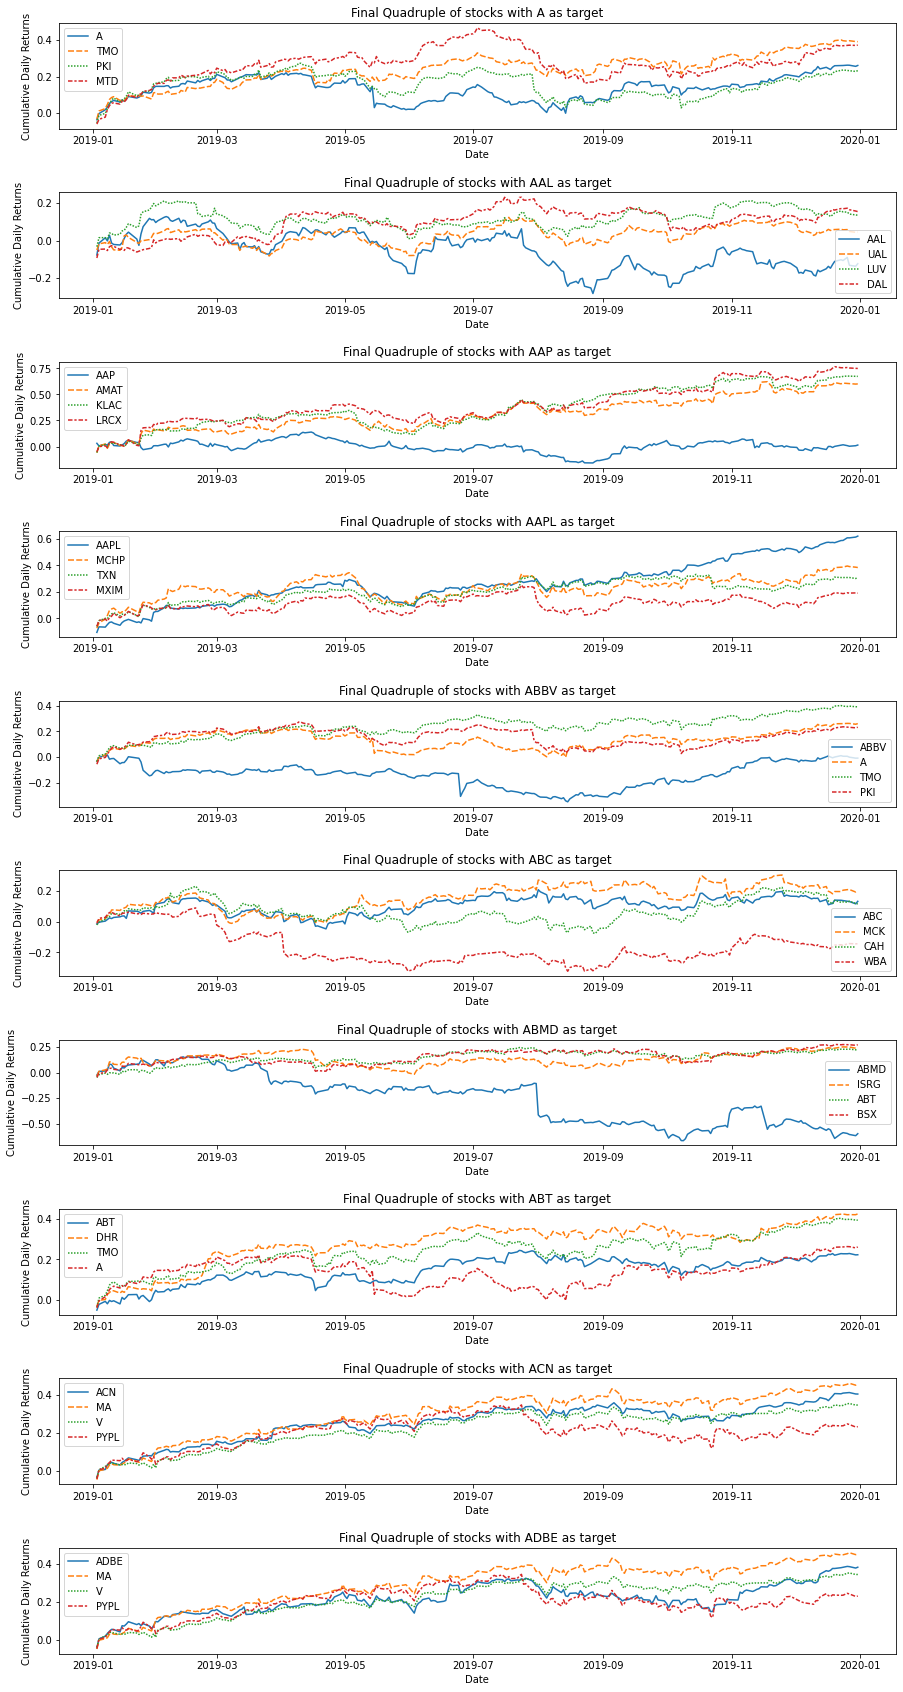

In [4]:
# Plotting the cumulative daily returns of the final quadruples.
ps.plot_selected_pairs(traditional_Q);

```get_sector_data``` returns name and sector data of stocks in the quadruple given as input.

In [5]:
# Displaying Name and Sector Info of Securities in the final Quadruples.
for quadruple in traditional_Q:
    display(get_sector_data(quadruple,constituents))

,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
A,Agilent Technologies,Health Care,Health Care Equipment
TMO,Thermo Fisher Scientific,Health Care,Life Sciences Tools & Services
PKI,PerkinElmer,Health Care,Health Care Equipment
MTD,Mettler Toledo,Health Care,Life Sciences Tools & Services


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AAL,American Airlines Group,Industrials,Airlines
UAL,United Airlines Holdings,Industrials,Airlines
LUV,Southwest Airlines,Industrials,Airlines
DAL,Delta Air Lines Inc.,Industrials,Airlines


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail
AMAT,Applied Materials Inc.,Information Technology,Semiconductor Equipment
KLAC,KLA Corporation,Information Technology,Semiconductor Equipment
LRCX,Lam Research,Information Technology,Semiconductor Equipment


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals"
MCHP,Microchip Technology,Information Technology,Semiconductors
TXN,Texas Instruments,Information Technology,Semiconductors
MXIM,Maxim Integrated Products Inc,Information Technology,Semiconductors


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ABBV,AbbVie Inc.,Health Care,Pharmaceuticals
A,Agilent Technologies,Health Care,Health Care Equipment
TMO,Thermo Fisher Scientific,Health Care,Life Sciences Tools & Services
PKI,PerkinElmer,Health Care,Health Care Equipment


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ABC,AmerisourceBergen Corp,Health Care,Health Care Distributors
MCK,McKesson Corp.,Health Care,Health Care Distributors
CAH,Cardinal Health Inc.,Health Care,Health Care Distributors
WBA,Walgreens Boots Alliance,Consumer Staples,Drug Retail


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ABMD,Abiomed,Health Care,Health Care Equipment
ISRG,Intuitive Surgical Inc.,Health Care,Health Care Equipment
ABT,Abbott Laboratories,Health Care,Health Care Equipment
BSX,Boston Scientific,Health Care,Health Care Equipment


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ABT,Abbott Laboratories,Health Care,Health Care Equipment
DHR,Danaher Corp.,Health Care,Health Care Equipment
TMO,Thermo Fisher Scientific,Health Care,Life Sciences Tools & Services
A,Agilent Technologies,Health Care,Health Care Equipment


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ACN,Accenture plc,Information Technology,IT Consulting & Other Services
MA,Mastercard Inc.,Information Technology,Data Processing & Outsourced Services
V,Visa Inc.,Information Technology,Data Processing & Outsourced Services
PYPL,PayPal,Information Technology,Data Processing & Outsourced Services


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ADBE,Adobe Inc.,Information Technology,Application Software
MA,Mastercard Inc.,Information Technology,Data Processing & Outsourced Services
V,Visa Inc.,Information Technology,Data Processing & Outsourced Services
PYPL,PayPal,Information Technology,Data Processing & Outsourced Services


## Extended Approach

Schmid and Schmidt (2007) introduce multivariate rank based measures of association.
This paper generalizes Spearman’s $\rho$ to arbitrary dimensions - a natural extension of the traditional approach.

In contrast to the strictly bi-variate case, this extended approach – and the two following approaches –
directly reflect multivariate dependence instead of approximating it by pairwise measures only.
This approach provides a more precise modeling of high dimensional association and thus a better performance in trading strategies.

The procedure is as follows:

- Calculate the multivariate version of Spearman’s $\rho$ for all possible quadruples, consisting of a fixed target stock.

- Quadruple with the largest value is considered the final quadruple and saved to the output matrix.

$d$ denotes the number of stocks daily returns observed from day $1$ to day $n$. $X_i$ denotes the $i$-th stock's return.

1. We calculate the empirical cumulative density function (ECDF) $\hat{F}_i$ for stock $i$.

2. Calculate quantile data for each $X_{i}$, by

$$
    \begin{align}
    \hat{U}_i = \frac{1}{n} (\text{rank of} \ X_i) = \hat{F}_i(X_i)
    \end{align}
$$

The formula for the three estimators are given below, as in the paper.

$$
    \begin{align}
       \hat{\rho}_1 = h(d) \times \Bigg\{-1 + \frac{2^d}{n} \sum_{j=1}^n \prod_{i=1}^d (1 - \hat{U}_{ij}) \Bigg\} \\
       \hat{\rho}_2 = h(d) \times \Bigg\{-1 + \frac{2^d}{n} \sum_{j=1}^n \prod_{i=1}^d \hat{U}_{ij} \Bigg\} \\
       \hat{\rho}_3 = -3 + \frac{12}{n {d \choose 2}} \times \sum_{k<l} \sum_{j=1}^n (1-\hat{U}_{kj})(1-\hat{U}_{lj}) \\
   \end{align}
$$

Where:

$$
    \begin{align}
       h(d) = \frac{d+1}{2^d - d -1}
    \end{align}
$$

We use the mean of the above three estimators as the final measure used to return the final quadruple.

In [6]:
# Calculating final quadruples using extended approach for first 10 target stocks.
extended_Q = ps.extended(10)
print(pd.Series(extended_Q))

0         [A, TMO, PKI, MTD]
1       [AAL, UAL, LUV, DAL]
2    [AAP, AMAT, KLAC, LRCX]
3    [AAPL, MCHP, TXN, MXIM]
4        [ABBV, A, TMO, PKI]
5       [ABC, MCK, CAH, WBA]
6     [ABMD, ISRG, ABT, BSX]
7         [ABT, DHR, TMO, A]
8         [ACN, MA, V, PYPL]
9        [ADBE, MA, V, PYPL]
dtype: object


## Geometric Approach

This approach tries to measure the geometric relation between the stocks in the quadruple.

Consider the relative ranks of a bi-variate random sample, where every observation takes on values in the $[0,1] \times [0,1]$ square.
If there exists a perfect linear relation among both the ranks of the components of the sample,
a plot of the relative ranks would result in a perfect line of dots between the points (0,0) and (1,1) – the diagonal line.
However, if this relation is not perfectly linear, at least one point differs from the diagonal.
The Euclidean distance of all ranks from the diagonal can be used as a measure of deviation from linearity, the diagonal measure.

Hence, we try to find the quadruple $Q$ that leads to the minimal value of the sum of these Euclidean distances.

The procedure is as follows:

- Calculate the four dimensional diagonal measure for all possible quadruples, consisting of a fixed target stock.

- Quadruple with the smallest diagonal measure is considered the final quadruple and saved to the output matrix.


The diagonal measure in four dimensional space is calculated using the following equation,

$$
    \begin{align}
    \sum_{i=1}^{n} | (P - P_{1}) - \frac{(P - P_{1}) \cdot (P_{2} - P_{1})}{| P_{2} -P_{1} |^{2}} (P_{2} - P_{1}) |
    \end{align}
$$

where,

$$
    \begin{align}
        P_{1} = (0,0,0,0), \\
        P_{2} = (1,1,1,1)
    \end{align}
$$

are points on the hyper-diagonal, and

$$
    \begin{align}
    P = (u_{1},u_{2},u_{3},u_{4})
    \end{align}
$$    

where $u_i$ represents the ranked returns of a stock $i$ in quadruple.

In [7]:
# Calculating final quadruples using geometric approach for first 10 target stocks.
geometric_Q = ps.geometric(10)
print(pd.Series(geometric_Q))

0           [A, TMO, PKI, WAT]
1             [AAL, GS, C, MS]
2      [AAP, AMAT, KLAC, LRCX]
3    [AAPL, GOOG, GOOGL, MSFT]
4    [ABBV, GOOG, GOOGL, MSFT]
5         [ABC, MCK, CAH, WBA]
6          [ABMD, PKI, A, TMO]
7           [ABT, DHR, TMO, A]
8           [ACN, MA, V, PYPL]
9          [ADBE, MSFT, MA, V]
dtype: object


In [8]:
#Showing output quadruples of the above three approaches,

display(pd.DataFrame([pd.Series(traditional_Q),pd.Series(extended_Q), pd.Series(geometric_Q)], index=['Traditional','Extended','Geometric']).T)

,Traditional,Extended,Geometric
0,"[A, TMO, PKI, MTD]","[A, TMO, PKI, MTD]","[A, TMO, PKI, WAT]"
1,"[AAL, UAL, LUV, DAL]","[AAL, UAL, LUV, DAL]","[AAL, GS, C, MS]"
2,"[AAP, AMAT, KLAC, LRCX]","[AAP, AMAT, KLAC, LRCX]","[AAP, AMAT, KLAC, LRCX]"
3,"[AAPL, MCHP, TXN, MXIM]","[AAPL, MCHP, TXN, MXIM]","[AAPL, GOOG, GOOGL, MSFT]"
4,"[ABBV, A, TMO, PKI]","[ABBV, A, TMO, PKI]","[ABBV, GOOG, GOOGL, MSFT]"
5,"[ABC, MCK, CAH, WBA]","[ABC, MCK, CAH, WBA]","[ABC, MCK, CAH, WBA]"
6,"[ABMD, ISRG, ABT, BSX]","[ABMD, ISRG, ABT, BSX]","[ABMD, PKI, A, TMO]"
7,"[ABT, DHR, TMO, A]","[ABT, DHR, TMO, A]","[ABT, DHR, TMO, A]"
8,"[ACN, MA, V, PYPL]","[ACN, MA, V, PYPL]","[ACN, MA, V, PYPL]"
9,"[ADBE, MA, V, PYPL]","[ADBE, MA, V, PYPL]","[ADBE, MSFT, MA, V]"


Comparing the outputs of the three approaches we can see sublte differences in the partners selected for the first 10 target stocks.

Traditional and Extended Approaches generate the exact same quadruples for all 10 targets.

For A, AAL, AAPL, ABBV, ABMD and ADBE, Geometric approach generated a different quadruple compared to the other two.

In [13]:
#Checking the sector data of quadruples for ticker 'AAPL',

#Quadruple generated by traditional and extended.
display(get_sector_data(['AAPL', 'MCHP', 'TXN', 'MXIM'] ,constituents))

#Quadruple generated by geometric approach.
display(get_sector_data(['AAPL', 'GOOG', 'GOOGL', 'MSFT'],constituents))

,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals"
MCHP,Microchip Technology,Information Technology,Semiconductors
TXN,Texas Instruments,Information Technology,Semiconductors
MXIM,Maxim Integrated Products Inc,Information Technology,Semiconductors


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals"
GOOG,Alphabet Inc. (Class C),Communication Services,Interactive Media & Services
GOOGL,Alphabet Inc. (Class A),Communication Services,Interactive Media & Services
MSFT,Microsoft Corp.,Information Technology,Systems Software


## Extremal Approach

Mangold (2015) proposes a nonparametric test for multivariate independence.
The resulting $\chi^2$ test statistic can be used to measure the degree of deviation from independence, so dependence.
The value of the measure increases on the occurence of an abnormal number of joint extreme events.


The procedure is as follows:

- Calculate the $\chi^2$ test statistic for all possible quadruples, consisting of a fixed target stock.

- Quadruple with the largest test statistic is considered the final quadruple and saved to the output matrix.

Given below are the steps to calculate the $\chi^2$ test statistic described in Proposition 3.3 of Mangold (2015):

These steps assume a 4-dimensional input.

1) Analytically calculate the 4-dimensional Nelsen copula from Definition 2.4 in Mangold (2015)


$$
    \begin{align}
    C_{\theta}(u_{1}, u_{2}, u_{3}, u_{4})
    \end{align}
$$


2) Analytically calculate the corresponding density function of 4-dimensional copula:


$$
    \begin{align}
       c_{\theta}(u_{1}, u_{2}, u_{3}, u_{4}) = \frac{\partial^{4}}{\partial u_{1} \partial u_{2} \partial u_{3}\partial u_{4}}C_{\theta}(u_{1}, u_{2}, u_{3}, u_{4})
    \end{align}
$$


3) Calculate the Partial Derivative of above density function $w.r.t \ \theta$.


$$
    \begin{align}
      \dot{c_{\theta}} = \frac{\partial c_{\theta}(u_{1}, u_{2}, u_{3}, u_{4})}{\partial \theta}
    \end{align}
$$


4) Calculate the Test Statistic for p-dimensional rank test:


$$
    \begin{align}
          T=n \boldsymbol{T}_{p, n}^{\prime} \Sigma\left(\dot{c}_{\theta_{0}}\right)^{-1} \boldsymbol{T}_{p, n} \stackrel{a}{\sim} \chi^{2}(q)
    \end{align}
$$

where,

$$
    \begin{align}
        \boldsymbol{T}_{p, n}=\mathbb{E}\left[\left.\frac{\partial}{\partial \theta} \log c_{\theta}(B)\right|_{\theta=\theta_{0}}\right] \\
    \\
    \Sigma\left(\dot{c}_{0}\right)_{i, j}=\int_{[0,1]^{p}}\left(\left.\frac{\partial c_{\theta}(\boldsymbol{u})}
    {\partial \theta_{i}}\right| _{\boldsymbol{\theta}=\mathbf{0}}\right) \times\left(\left.\frac{\partial c_{\theta}(\boldsymbol{u})}
    {\partial \theta_{j}}\right |_{\theta=0}\right) \mathrm{d} \boldsymbol{u}
    \end{align}
$$




In [11]:
# Calculating final quadruples using extremal approach for first 10 target stocks.
extremal_Q = ps.extremal(10)
print(pd.Series(extremal_Q))

0           [A, TMO, PKI, DHR]
1         [AAL, UAL, DAL, ALK]
2         [AAP, GPC, PNR, DOV]
3    [AAPL, GOOG, GOOGL, MSFT]
4          [ABBV, A, TMO, DHR]
5         [ABC, MCK, CAH, WBA]
6       [ABMD, ISRG, ABT, BSX]
7        [ABT, BSX, SYK, ISRG]
8           [ACN, MA, V, VRSN]
9          [ADBE, MSFT, MA, V]
dtype: object


In [12]:
#Showing output quadruples of the above four approaches,

display(pd.DataFrame([pd.Series(traditional_Q),pd.Series(extended_Q), pd.Series(geometric_Q), pd.Series(extremal_Q)], index=['Traditional','Extended','Geometric', 'Extremal']).T)

,Traditional,Extended,Geometric,Extremal
0,"[A, TMO, PKI, MTD]","[A, TMO, PKI, MTD]","[A, TMO, PKI, WAT]","[A, TMO, PKI, DHR]"
1,"[AAL, UAL, LUV, DAL]","[AAL, UAL, LUV, DAL]","[AAL, GS, C, MS]","[AAL, UAL, DAL, ALK]"
2,"[AAP, AMAT, KLAC, LRCX]","[AAP, AMAT, KLAC, LRCX]","[AAP, AMAT, KLAC, LRCX]","[AAP, GPC, PNR, DOV]"
3,"[AAPL, MCHP, TXN, MXIM]","[AAPL, MCHP, TXN, MXIM]","[AAPL, GOOG, GOOGL, MSFT]","[AAPL, GOOG, GOOGL, MSFT]"
4,"[ABBV, A, TMO, PKI]","[ABBV, A, TMO, PKI]","[ABBV, GOOG, GOOGL, MSFT]","[ABBV, A, TMO, DHR]"
5,"[ABC, MCK, CAH, WBA]","[ABC, MCK, CAH, WBA]","[ABC, MCK, CAH, WBA]","[ABC, MCK, CAH, WBA]"
6,"[ABMD, ISRG, ABT, BSX]","[ABMD, ISRG, ABT, BSX]","[ABMD, PKI, A, TMO]","[ABMD, ISRG, ABT, BSX]"
7,"[ABT, DHR, TMO, A]","[ABT, DHR, TMO, A]","[ABT, DHR, TMO, A]","[ABT, BSX, SYK, ISRG]"
8,"[ACN, MA, V, PYPL]","[ACN, MA, V, PYPL]","[ACN, MA, V, PYPL]","[ACN, MA, V, VRSN]"
9,"[ADBE, MA, V, PYPL]","[ADBE, MA, V, PYPL]","[ADBE, MSFT, MA, V]","[ADBE, MSFT, MA, V]"


For AAP, ABT and ACN Extremal Approach generates different final quadruple compared to the other three methods.

In [14]:
#Checking the sector data of quadruples for ticker 'ABT',

#Quadruple generated by traditional and extended.
display(get_sector_data(['ABT', 'DHR', 'TMO', 'A'] ,constituents))

#Quadruple generated by geometric approach.
display(get_sector_data(['ABT', 'BSX', 'SYK', 'ISRG'],constituents))

,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ABT,Abbott Laboratories,Health Care,Health Care Equipment
DHR,Danaher Corp.,Health Care,Health Care Equipment
TMO,Thermo Fisher Scientific,Health Care,Life Sciences Tools & Services
A,Agilent Technologies,Health Care,Health Care Equipment


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ABT,Abbott Laboratories,Health Care,Health Care Equipment
BSX,Boston Scientific,Health Care,Health Care Equipment
SYK,Stryker Corp.,Health Care,Health Care Equipment
ISRG,Intuitive Surgical Inc.,Health Care,Health Care Equipment


## Conclusion

This notebook describes the proposed Partner Selection Framework, also showcasing example usage of the implemented framework.

The first two procedures seem to generate the same final set of quadruples for every target stock in the universe. Another important takeaway is the Industry/Sub-Sector of the stocks in most of the final quadruples are highly correlated, even though clustering methods were not used in this framework.

## References

* [Stübinger, Johannes; Mangold, Benedikt; Krauss, Christopher; 2016. Statistical Arbitrage with Vine Copulas.](https://www.econstor.eu/bitstream/10419/147450/1/870932616.pdf)
* [Schmid, F., Schmidt, R., 2007. Multivariate extensions of Spearman’s rho and related statis-tics. Statistics & Probability Letters 77 (4), 407–416.](https://wisostat.uni-koeln.de/fileadmin/sites/statistik/pdf_publikationen/SchmidSchmidtSpearmansRho.pdf)
* [Mangold, B., 2015. A multivariate linear rank test of independence based on a multipara-metric copula with cubic sections. IWQW Discussion Paper Series, University of Erlangen-N ̈urnberg.](https://www.statistik.rw.fau.de/files/2016/03/IWQW-10-2015.pdf)

